# GRU

### LIBRERÍAS

In [10]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, TimeDistributed
from tensorflow.keras.losses import mean_squared_error

### CARGA DE COMPLETE RENTALS DF & WEATHER DF

In [11]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_LOG1P.csv')

In [12]:
completeRentalsDf['Date'] = pd.to_datetime(completeRentalsDf['Date'])
completeRentalsDf.set_index('Date', inplace=True)

In [13]:
completeWeatherDf = pd.read_csv('../data/completeData/weather/completeWeatherDf.csv')

In [14]:
def getTrainValidationTestStationT24T48T168_ExogVariables(trainDays, validationDays, station, completeRentalsDf, completeWeatherDf):
    X_24 = np.delete(completeRentalsDf[[station]].values.reshape(-1, 24), [range(0, 6)], 0)
    X_48 = completeRentalsDf[[station]].values.reshape(-1, 24)
    X_48 = np.delete(X_48, [range(0, 5)], 0)
    X_48 = np.delete(X_48, len(X_48)-1, 0)
    X_168 = completeRentalsDf[[station]].values.reshape(-1, 24)
    X_168 = np.delete(X_168, [[len(X_168)-i for i in range(1, 7)]], 0)

    X_temp = np.delete(completeWeatherDf['temp'].values.reshape(-1, 24), [range(0, 7)], 0)
    X_humidity = np.delete(completeWeatherDf['humidity'].values.reshape(-1, 24), [range(0, 7)], 0)

    X = np.append( np.append( X_168, X_48, axis=1), X_24, axis = 1)
    X = np.delete(X, len(X)-1, 0)
    X = np.append( np.append( X_temp, X_humidity, axis=1), X, axis=1).reshape(-1,5, 24)

    X_transposed = np.empty((len(X), 24, 5))
    for i in range(0, len(X)):
        X_transposed[i] = X[i].transpose()

    X = X_transposed
    Y = np.delete(X_24, 0, 0)

    X_train, Y_train = X[0:trainDays], Y[0:trainDays]
    X_validation, Y_validation = X[trainDays:trainDays+validationDays], Y[trainDays:trainDays+validationDays]
    X_test , Y_test = X[trainDays+validationDays:X.shape[0]], Y[trainDays+validationDays:Y.shape[0]]

    print("Shape del dataframe 'X_train' --> {} // 'X_validation --> {} //  X_test --> {}".format(X_train.shape,X_validation.shape, X_test.shape))
    print("Shape del dataframe 'Y_train' --> {} // 'Y_validation --> {} // Y_test --> {}".format(Y_train.shape, Y_validation.shape, Y_test.shape))
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

In [15]:
def plotDayPrediction(predictions, Y, day, log1pData):

    data = pd.DataFrame()
    try:
        if log1pData:
            data['prediction'] = np.round(np.expm1(predictions[day]),0)
            data['real'] = np.expm1(Y[day])
        else:
            data['prediction'] = np.round(predictions[day],0)
            data['real'] = Y[day]
    except:
        print("El dia tiene que ser inferior a {}".format(len(Y)) )

    plt.figure(figsize=(12,5))
    plt.xlabel('Prediction of day ' + str(day))

    ax1 = data.prediction.plot(color='red', grid=True, label='Forecast')
    ax2 = data.real.plot(color='blue', grid=True, label='Actual')
    h1, l1 = ax1.get_legend_handles_labels()

    plt.legend(h1, l1, loc=2)
    plt.show()

In [16]:
def log1p_mse_rmse(Y_test, predictions):
    rmse = 0
    mse = 0
    for i in range(0, len(predictions)):
        mse += mean_squared_error(np.expm1(Y_test[i]), np.expm1(predictions[i]))

    mse /= len(predictions)
    rmse += math.sqrt(mse)
    print("MSE = {}, RMSE = {}".format(mse,rmse))

In [17]:
epochs = 10000
batch_size = 4096

### GRU CON DISTRIBUTED LAYER [MANY TO MANY] t-24h, t-48h & t-168h + Exogenous Variables

In [27]:
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = getTrainValidationTestStationT24T48T168_ExogVariables(4000, 102, '31201', completeRentalsDf, completeWeatherDf)

Shape del dataframe 'X_train' --> (4000, 24, 5) // 'X_validation --> (102, 24, 5) //  X_test --> (102, 24, 5)
Shape del dataframe 'Y_train' --> (4000, 24) // 'Y_validation --> (102, 24) // Y_test --> (102, 24)


#### MODELO SIMPLE LOG1P

In [28]:
model = Sequential()
model.add(GRU(X_train.shape[1], input_shape=(X_train.shape[1], 5), return_sequences=True, name='GRU_1'))
model.add(TimeDistributed(Dense(1, activation="relu", name="Dense_1")))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_1 (GRU)                  (None, 24, 24)            2232      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 1)             25        
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1), batch_size=batch_size, epochs=epochs)

Epoch 1/10000
1/1 [==============================] - 1s 775ms/step - loss: 1.8694 - mae: 1.1282
Epoch 2/10000
1/1 [==============================] - 0s 89ms/step - loss: 1.7948 - mae: 1.1093
Epoch 3/10000
1/1 [==============================] - 0s 27ms/step - loss: 1.7270 - mae: 1.0917
Epoch 4/10000
1/1 [==============================] - 0s 25ms/step - loss: 1.6649 - mae: 1.0750
Epoch 5/10000
1/1 [==============================] - 0s 23ms/step - loss: 1.6075 - mae: 1.0591
Epoch 6/10000
1/1 [==============================] - 0s 23ms/step - loss: 1.5541 - mae: 1.0440
Epoch 7/10000
1/1 [==============================] - 0s 31ms/step - loss: 1.5041 - mae: 1.0294
Epoch 8/10000
1/1 [==============================] - 0s 23ms/step - loss: 1.4571 - mae: 1.0153
Epoch 9/10000
1/1 [==============================] - 0s 7ms/step - loss: 1.4127 - mae: 1.0017
Epoch 10/10000
1/1 [==============================] - 0s 7ms/step - loss: 1.3706 - mae: 0.9885
Epoch 11/10000
1/1 [==============================

In [30]:
score = model.evaluate(X_validation, Y_validation.reshape(Y_validation.shape[0], Y_validation.shape[1], 1), batch_size=batch_size, verbose=0)
for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))
predictions = model.predict(x=X_validation, batch_size=batch_size, verbose=0).reshape(-1, 24)
log1p_mse_rmse(Y_validation, predictions)

 Test rmse: 0.5144652125532342
 Test loss: 0.26467445492744446
 Test mae: 0.3910170793533325
MSE = 6.064512252807617, RMSE = 2.4626230431813183


MSE = 4.051900386810303, RMSE = 2.0129332792743786


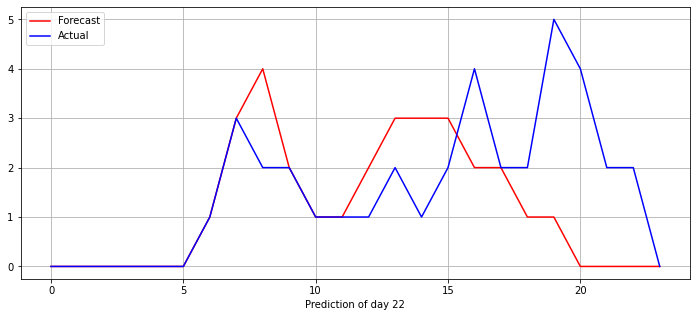

In [31]:
predictions = model.predict(x=X_test, batch_size=batch_size, verbose=0).reshape(-1,24)
log1p_mse_rmse(Y_test, predictions)
plotDayPrediction(predictions, Y_test, 22, True)

#### MODELO MAS DENSO LOG1P

In [34]:
model = Sequential()
model.add(GRU(X_train.shape[1], input_shape=(X_train.shape[1], 5), return_sequences=True, name='GRU_1'))
model.add(TimeDistributed(Dense(16, activation="relu", name="Dense_1")))
model.add(Dense(8, activation='relu', name='Dense_2'))
model.add(Dense(4, activation='relu', name='Dense_3'))
model.add(Dense(2, activation='relu', name='Dense_4'))
model.add(Dense(1, activation='relu', name='Dense_5'))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_1 (GRU)                  (None, 24, 24)            2232      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 16)            400       
_________________________________________________________________
Dense_2 (Dense)              (None, 24, 8)             136       
_________________________________________________________________
Dense_3 (Dense)              (None, 24, 4)             36        
_________________________________________________________________
Dense_4 (Dense)              (None, 24, 2)             10        
_________________________________________________________________
Dense_5 (Dense)              (None, 24, 1)             3         
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
____________________________________________________

In [35]:
with tf.device('/GPU:0'):
    model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1), batch_size=batch_size, epochs=epochs)

Epoch 1/10000
1/1 [==============================] - 1s 888ms/step - loss: 1.7807 - mae: 1.0965
Epoch 2/10000
1/1 [==============================] - 0s 54ms/step - loss: 1.6061 - mae: 1.0453
Epoch 3/10000
1/1 [==============================] - 0s 39ms/step - loss: 1.4432 - mae: 0.9967
Epoch 4/10000
1/1 [==============================] - 0s 65ms/step - loss: 1.2998 - mae: 0.9521
Epoch 5/10000
1/1 [==============================] - 0s 53ms/step - loss: 1.1820 - mae: 0.9140
Epoch 6/10000
1/1 [==============================] - 0s 48ms/step - loss: 1.0898 - mae: 0.8825
Epoch 7/10000
1/1 [==============================] - 0s 9ms/step - loss: 1.0203 - mae: 0.8570
Epoch 8/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.9696 - mae: 0.8372
Epoch 9/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.9336 - mae: 0.8216
Epoch 10/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.9082 - mae: 0.8095
Epoch 11/10000
1/1 [=============================

In [36]:
score = model.evaluate(X_validation, Y_validation.reshape(Y_validation.shape[0], Y_validation.shape[1], 1), batch_size=batch_size, verbose=0)
for i,metric in enumerate(model.metrics_names):
    if (metric =='loss'): print(' Test rmse: {}'.format( math.sqrt(score[i])))
    print(' Test {}: {}'.format(metric, score[i]))
predictions = model.predict(x=X_validation, batch_size=batch_size, verbose=0).reshape(-1, 24)
log1p_mse_rmse(Y_validation, predictions)

 Test rmse: 0.5162281496813422
 Test loss: 0.26649150252342224
 Test mae: 0.3940928876399994
MSE = 6.243138790130615, RMSE = 2.4986273812096544


MSE = 3.888489007949829, RMSE = 1.971925203436943


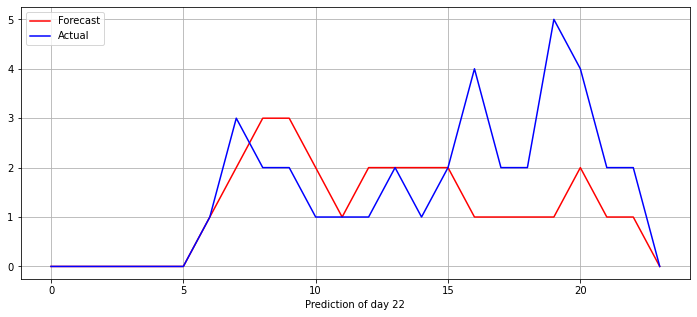

In [37]:
predictions = model.predict(x=X_test, batch_size=batch_size, verbose=0).reshape(-1,24)
log1p_mse_rmse(Y_test, predictions)
plotDayPrediction(predictions, Y_test, 22, True)